<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [ ]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

# Data Cleaning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, date
from sklearn.cluster import KMeans

## Order Dataset

In [ ]:
order_df = pd.read_csv('olist_orders_dataset.csv')
order_df.info()

In [ ]:
order_df[order_df.duplicated()]

In [ ]:
order_df.drop(['order_status',
               'order_delivered_carrier_date',
               'order_approved_at',
               'order_purchase_timestamp'], axis='columns', inplace=True)
#for column in ['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
#    order_df[column] = pd.to_datetime(order_df[column])
#order_df.info()

for column in ['order_delivered_customer_date', 'order_estimated_delivery_date']:
    order_df[column] = pd.to_datetime(order_df[column])
order_df.info()

In [ ]:
order_df.head()

## Payment Dataset

In [ ]:
payment_df = pd.read_csv('olist_order_payments_dataset.csv')
payment_df.info()

In [ ]:
payment_df[payment_df.duplicated()]

In [ ]:
payment_df.head()

In [ ]:
payment_df.describe()

In [ ]:
payment_df.nunique()

## Customer Dataset

In [ ]:
customer_df = pd.read_csv('olist_customers_dataset.csv')
customer_df.info()

In [ ]:
customer_df[customer_df.duplicated()]

In [ ]:
customer_df.drop(['customer_zip_code_prefix', 'customer_city'], axis='columns', inplace=True)

In [ ]:
customer_df.nunique()

In [ ]:
customer_df.head()

## Item Dataset

In [ ]:
item_df = pd.read_csv('olist_order_items_dataset.csv')

In [ ]:
item_df.info()

In [ ]:
item_df[item_df.duplicated()]

In [ ]:
'''
item_df.drop(['seller_id',
              'shipping_limit_date',
              'price',
              'freight_value',
              'order_item_id'], axis='columns', inplace=True)
item_df.columns
'''

In [ ]:
item_df.head()

## Product Dataset

In [ ]:
product_df = pd.read_csv('olist_products_dataset.csv')

In [ ]:
product_df.info()

In [ ]:
product_df[product_df.duplicated()]

In [ ]:
'''
product_df.drop(['product_name_lenght',
                 'product_description_lenght', 
                 'product_photos_qty', 
                 'product_weight_g',
                 'product_length_cm',
                 'product_height_cm',
                 'product_width_cm'], axis='columns', inplace=True)
'''

In [ ]:
product_df.fillna(product_df.median(), inplace=True)
product_df.info()

In [ ]:
product_df.fillna('other', inplace=True)
product_df.info()

In [ ]:
product_df.head()

In [ ]:
product_df.product_category_name.nunique()

## Translation Dataset

In [ ]:
translation_df = pd.read_csv('product_category_name_translation.csv')
translation_df.info()
translation_df.head()

## Review Dataset

In [ ]:
review_df = pd.read_csv('olist_order_reviews_dataset.csv')
review_df.info()

In [ ]:
review_df[review_df.duplicated()]

In [ ]:
review_df.drop(['review_id', 'review_creation_date', 'review_answer_timestamp'], axis='columns', inplace=True)
review_df.columns

In [ ]:
for columns in ['review_comment_title', 'review_comment_message']:
    # replace present values with 1
    review_df.loc[review_df[columns].notnull(), columns] = 1
    # replace null values with 0
    review_df.loc[review_df[columns].isna(), columns] = 0
review_df.info()

In [ ]:
review_df.head()

In [ ]:
review_df.nunique()

In [ ]:
review_df.review_score.value_counts(normalize=True)

In [ ]:
plt.bar(review_df.review_score.value_counts().index, review_df.review_score.value_counts().values)

## Seller Dataset

In [ ]:
seller_df = pd.read_csv('olist_sellers_dataset.csv')
seller_df.info()

In [ ]:
seller_df.drop(['seller_zip_code_prefix', 'seller_city'], axis='columns', inplace=True)
seller_df.columns

# Exploratory Data Analytics with Raw Data

In [ ]:
ro_df = pd.merge(review_df, order_df, how='left', on='order_id')
ro_df.info()
ro_df.head()

In [ ]:
roc_df = pd.merge(ro_df, customer_df, how='left', on='customer_id')
roc_df.drop(['customer_id', 'customer_unique_id'], axis='columns', inplace=True)
roc_df.info()
roc_df.head()

In [ ]:
rocp_df = pd.merge(roc_df, payment_df, on='order_id')
rocp_df.drop('payment_sequential', axis='columns', inplace=True)
rocp_df.info()
rocp_df.head()

In [ ]:
rocpi_df = pd.merge(rocp_df, item_df, on='order_id')
rocpi_df.drop(['order_id', 'shipping_limit_date', 'order_item_id'], axis='columns', inplace=True)
rocpi_df.info()
rocpi_df.head()

In [ ]:
rocpip_df = pd.merge(rocpi_df, product_df, on='product_id')
rocpip_df.drop('product_id', axis='columns', inplace=True)
rocpip_df.info()
rocpip_df.head()

In [ ]:
rocpips_df = pd.merge(rocpip_df, seller_df, on='seller_id')
rocpips_df.drop('seller_id', axis='columns', inplace=True)
rocpips_df.info()
rocpips_df.head()

## Feature Engineering

In [ ]:
rocpips_df['delay'] = (rocpips_df.order_delivered_customer_date - rocpips_df.order_estimated_delivery_date).dt.days
rocpips_df.drop(['order_delivered_customer_date', 'order_estimated_delivery_date'], axis='columns', inplace=True)
rocpips_df.fillna(rocpips_df.median(), inplace=True)

In [ ]:
rocpips_df

## Linear Modeling

In [ ]:
dummies_df = pd.get_dummies(rocpips_df)

In [ ]:
dummies_df.info()
dummies_df.head()

In [ ]:
target = dummies_df.review_score
df = dummies_df.drop('review_score', axis='columns')
df['review_score'] = target
df

In [ ]:
from scipy import stats
corr_array=[]
for i in range(df.shape[1]-1):  
    corr_array.append([df.columns[i],
                       np.abs(stats.pearsonr(df[df.columns[i]], df[df.columns[-1]])[0]),
                       stats.pearsonr(df[df.columns[i]], df[df.columns[-1]])[0],
                       stats.pearsonr(df[df.columns[i]], df[df.columns[-1]])[1]])
    
corr_df = pd.DataFrame(corr_array, columns = ['feature', 'abs_corr', 'corr', 'p_value'])
corr_df.sort_values(by='abs_corr', ascending=False, inplace=True)
corr_df.reset_index(drop=True, inplace=True)
corr_df

In [ ]:
corr_df.head(10)

In [ ]:
df[df.columns[:-1]]

In [ ]:
'''
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# logistic regression 
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('Train Accuracy: ', lr.score(X_train, y_train))
print('Test Accuracy: ', lr.score(X_test, y_test))

In [57]:
df.loc[df.review_score < 5, 'review_score'] = 0
df.loc[df.review_score == 5, 'review_score'] = 1

In [61]:
# variance inflation factors
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF_series = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
VIF_series.sort_values(ascending=False, inplace=True)

seller_state_SP                                 inf
product_category_name_eletroportateis           inf
product_category_name_alimentos                 inf
product_category_name_alimentos_bebidas         inf
product_category_name_artes                     inf
                                             ...   
product_photos_qty                         1.173839
review_comment_title                       1.148259
review_comment_message                     1.138200
product_name_lenght                        1.118339
delay                                      1.040132
Length: 142, dtype: float64

         Current function value: 0.650620
         Iterations: 35


C:\Users\arali\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           review_score   No. Observations:               118315
Model:                          Logit   Df Residuals:                   118176
Method:                           MLE   Df Model:                          138
Date:                Tue, 17 Mar 2020   Pseudo R-squ.:                 0.05115
Time:                        20:38:52   Log-Likelihood:                -76978.
converged:                      False   LL-Null:                       -81128.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================================================
                                                                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------
const                                                                    0.2507      7.510      0.033      0.973     -14.468      14.970
review_comment_title                                                     0.0732      0.006     11.340      0.000       0.061       0.086
review_comment_message                                                  -0.3291      0.006    -51.080      0.000      -0.342      -0.316
payment_installments                                                     0.0022      0.007      0.301      0.764      -0.012       0.016
payment_value                                                           -0.3552      0.015    -24.222      0.000      -0.384      -0.326
price                                                                    0.2738      0.012     22.006      0.000       0.249       0.298
freight_value                                                           -0.0096      0.009     -1.017      0.309      -0.028       0.009
product_name_lenght                                                     -0.0248      0.006     -3.849      0.000      -0.037      -0.012
product_description_lenght                                               0.0062      0.007      0.909      0.364      -0.007       0.019
product_photos_qty                                                       0.0078      0.007      1.187      0.235      -0.005       0.021
product_weight_g                                                         0.0182      0.010      1.760      0.078      -0.002       0.038
product_length_cm                                                       -0.0203      0.008     -2.517      0.012      -0.036      -0.004
product_height_cm                                                       -0.0301      0.008     -3.570      0.000      -0.047      -0.014
product_width_cm                                                         0.0070      0.008      0.837      0.403      -0.009       0.023
delay                                                                   -0.3650      0.007    -51.380      0.000      -0.379      -0.351
customer_state_AC                                                       -0.0047        nan        nan        nan         nan         nan
customer_state_AL                                                       -0.0124        nan        nan        nan         nan         nan
customer_state_AM                                                       -0.0051        nan        nan        nan         nan         nan
customer_state_AP                                                       -0.0094        nan        nan        nan         nan         nan
customer_state_BA                                                       -0.0432        nan        nan        nan         nan         nan
customer_state_CE                                                       -0.0200        nan

Text(0.5, 0, 'normalized coefficient')

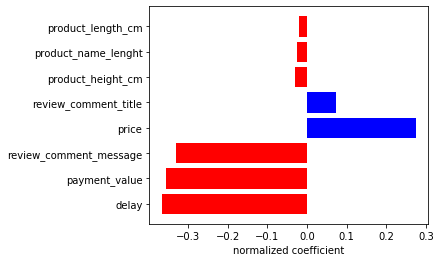

In [59]:
# seperate target from features
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

# scale data with standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

# fit logit function 
import statsmodels.api as sm
X_withconstant = sm.add_constant(X)
logit = sm.Logit(y, X_withconstant).fit()
display(logit.summary()) 

# table of significant coefficinets sorted by absolute value
coef_table = summary.tables[1]
coef_df = pd.DataFrame(data=coef_table.data[1:], columns=coef_table.data[0])
coef_df['coef'] = coef_df['coef'].astype(float)
coef_df['P>|z|'] = coef_df['P>|z|'].astype(float)
coef_df['abs_coef'] = np.abs(coef_df['coef'])
coef_df.drop(0, axis='index', inplace=True)
coefs_by_mag = coef_df.sort_values(by='abs_coef', ascending=False)
coefs_by_mag = coefs_by_mag[coefs_by_mag['P>|z|'] <= 0.05]

# bar chart of feature coefficients
bar_names = coefs_by_mag['']
bar_heights = coefs_by_mag['coef']
bar_colors = np.where(bar_heights>0, 'blue', 'red')
plt.figure(figsize=(5.0, 4.0))
plt.barh(bar_names, bar_heights, color=bar_colors)
plt.xlabel('normalized coefficient')

In [ ]:
import statsmodels.api as sm
X_withconstant = sm.add_constant(X)
logit = sm.Logit(y, X_withconstant).fit()
summary = logit.summary()
display(summary)

## Review Dataset

In [ ]:
review_df = pd.read_csv('olist_order_reviews_dataset.csv')
review_df.info()

In [ ]:
df.groupby('review_score').mean()

In [ ]:
plt.bar(df.columns[:-1], df.groupby('review_score').mean().iloc[0])

In [ ]:
review_df[review_df.duplicated()]

In [ ]:
review_df.drop(['review_id', 'review_creation_date', 'review_answer_timestamp'], axis='columns', inplace=True)
review_df.columns

In [ ]:
for columns in ['review_comment_title', 'review_comment_message']:
    # replace present values with 1
    review_df.loc[review_df[columns].notnull(), columns] = 1
    # replace null values with 0
    review_df.loc[review_df[columns].isna(), columns] = 0
review_df.info()

In [ ]:
review_df.head()

In [ ]:
review_df.nunique()

In [ ]:
plt.bar(payment_df.groupby('payment_type').sum().index, 
        payment_df.groupby('payment_type').sum()['payment_value']/payment_df.groupby('payment_type').count()['payment_value']);

In [ ]:
plt.scatter(payment_df.payment_installments, payment_df.payment_value);

In [ ]:
plt.hist(review_df.review_score);

In [ ]:
po_df = pd.merge(payment_df, order_df, how='left', on='order_id')
po_df.info()
po_df.head()

In [ ]:
poc_df = pd.merge(po_df, customer_df, how='left', on='customer_id')
poc_df.drop('customer_id', axis='columns', inplace=True)
poc_df.info()
poc_df.head()

In [ ]:
state_pay_series = poc_df.groupby('customer_state').sum()['payment_value']/poc_df.groupby('customer_state').count()['payment_value']
state_pay_series.sort_values(inplace=True, ascending=False)
plt.bar(state_pay_series.index, state_pay_series);

In [ ]:
poci_df = pd.merge(poc_df, item_df, how='right', on='order_id')
poci_df.info()

In [ ]:
poci_df.drop(poci_df[poci_df.payment_value.isnull()].index, axis='index', inplace=True)
poci_df.info()

In [ ]:
pocip_df = pd.merge(poci_df, product_df, how='left', on='product_id')
pocip_df.drop('product_id', axis='columns', inplace=True)
pocip_df.info()
pocip_df.head()

In [ ]:
#df = pd.merge(df, translation_df, how='left', on='product_category_name')
#df.drop('product_category_name', axis='columns', inplace=True)
#df.head()

In [ ]:
payment_by_category = pocip_df.groupby('product_category_name')['payment_value'].sum()
payment_by_category.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12,20))
plt.barh(payment_by_category.index, payment_by_category)

In [ ]:
pocipr_df = pd.merge(pocip_df, review_df, how='right', on='order_id')
pocipr_df.info()
pocipr_df.head()

In [ ]:
pocipr_df.drop(pocipr_df[pocipr_df.payment_value.isnull()].index, axis='index', inplace=True)
pocipr_df.info()

# Feature Engineering

In [ ]:
pocipr_df['purchase_date'] = pocipr_df['order_purchase_timestamp'].dt.date
pocipr_df['delay'] = (pocipr_df.order_delivered_customer_date - pocipr_df.order_estimated_delivery_date).dt.days
pocipr_df.drop(['order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date'], axis='columns', inplace=True)
pocipr_df.head()

In [ ]:
pocipr_df.info()

In [ ]:
pocipr_df.fillna(pocipr_df.median(), inplace=True)

In [ ]:
pocipr_df.info()

In [ ]:
plt.hist(pocipr_df.delay, bins=50);

In [ ]:
plt.scatter(pocipr_df.purchase_date, pocipr_df.delay);

In [ ]:
pocipr_df.head()

In [ ]:
pocipr_df1 = pocipr_df[(date(2016,10,1) <= pocipr_df.purchase_date) & (pocipr_df.purchase_date < date(2018,4,1))]
pocipr_df2 = pocipr_df[(date(2018,4,1) <= pocipr_df.purchase_date) & (pocipr_df.purchase_date < date(2018,10,1))]
pocipr_df2 = pocipr_df2[['customer_unique_id', 'payment_value']]

In [ ]:
pocipr_df1

In [ ]:
pocipr_df2

# Exploratory Data Analytics

In [ ]:
cust_pocipr_df1 = pocipr_df1.groupby('customer_unique_id').agg({'purchase_date': lambda x: min((max(pocipr_df1.purchase_date)-x).dt.days),  
                                                    'order_id': 'count',
                                                    'payment_value': 'sum',
                                                    'delay': 'mean',
                                                    'payment_installments': 'mean',
                                                    'review_score': 'mean',
                                                    'review_comment_title': 'mean',
                                                    'review_comment_message': 'mean',
                                           'payment_type': lambda x: x.value_counts().index[0],
                                           'product_category_name': lambda x: x.value_counts().index[0],
                                                'customer_state': lambda x: x.value_counts().index[0]})



In [ ]:
cust_pocipr_df1.columns = ['recency', 'frequency', 'monetary', 'delay', 'installments', 'review_score', 'comment_title', 'comment_message',
            'pop_payment_type', 'pop_category', 'customer_state']

cust_pocipr_df1

In [ ]:
cust_pocipr_df1.head()

In [ ]:
cust_pocipr_df1.to_csv('cust_pocipr_df1.csv', index=True);
#cust_pocipr_df1 = pd.read_csv('cust_pocipr_df1.csv', index_col=0)

In [ ]:
cust_pocipr_df1

In [ ]:
#cust_pocipr_df1['customer_state'] = pocipr_df1.groupby('customer_unique_id').agg({'customer_state': lambda x: x.value_counts().index[0]})
#cust_pocipr_df1

In [ ]:
#cust_pocipr_df1 = pd.merge(cust_pocipr_df1, customer_df.set_index('customer_unique_id')['customer_state'], how='left', left_index=True, right_index=True)
#cust_pocipr_df1

In [ ]:
cust_pocipr_df1

In [ ]:
feature_df = pd.get_dummies(cust_pocipr_df1)
feature_df

In [ ]:
target_df = pocipr_df2.groupby('customer_unique_id').agg({'payment_value':'sum'})
target_df

In [ ]:
df = pd.merge(feature_df, target_df, on='customer_unique_id')
df.info()
df.head()

In [ ]:
df = df.loc[:, (df != df.iloc[0]).any()] 

## Corrlation Analysis

In [ ]:
from scipy import stats
corr_array=[]
for i in range(df.shape[1]-1):  
    corr_array.append([df.columns[i], 
    np.abs(stats.pearsonr(df[df.columns[i]], df.payment_value)[0]),
    stats.pearsonr(df[df.columns[i]], df.payment_value)[0],
    stats.pearsonr(df[df.columns[i]], df.payment_value)[1]])
    
    
    
corr_df = pd.DataFrame(corr_array, columns = ['Info', 'abs_corr', 'corr', 'p_value'])
corr_df.sort_values(by = 'abs_corr', ascending = False, inplace = True)
corr_df.reset_index(drop = True, inplace = True)
corr_df

In [ ]:
plt.scatter(df.monetary, df.payment_value)

In [ ]:
plt.scatter(df.frequency, df.payment_value)

In [ ]:
plt.scatter(df.installments, df.payment_value)

In [ ]:
plt.scatter(df.pop_category_relogios_presentes, df.payment_value)

In [ ]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# logistic regression 
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Train Accuracy: ', lr.score(X_train, y_train))
print('Test Accuracy: ', lr.score(X_test, y_test))

## Quartile-based

In [ ]:
df_q4 = df
df_q4.payment_value = pd.qcut(df_q4.payment_value, 4, labels=[1, 2, 3, 4])
df_q4

In [ ]:
from scipy import stats
corr_array=[]
for i in range(df_q4.shape[1]-1):  
    corr_array.append([df_q4.columns[i], 
    np.abs(stats.pearsonr(df_q4[df_q4.columns[i]], df_q4.payment_value)[0]),
    stats.pearsonr(df_q4[df_q4.columns[i]], df_q4.payment_value)[0],
    stats.pearsonr(df_q4[df_q4.columns[i]], df_q4.payment_value)[1]])
        
corr_df_q4 = pd.DataFrame(corr_array, columns = ['Info', 'abs_corr', 'corr', 'p_value'])
corr_df_q4.sort_values(by = 'abs_corr', ascending = False, inplace = True)
corr_df_q4.reset_index(drop = True, inplace = True)
corr_df_q4

## Binary

In [ ]:
df_q2 = df
df_q2.payment_value = pd.qcut(df_q2.payment_value, 2, labels=[0, 1])
df_q2

In [ ]:
from scipy import stats
corr_array=[]
for i in range(df_q2.shape[1]-1):  
    corr_array.append([df_q2.columns[i], 
    np.abs(stats.pearsonr(df_q2[df_q2.columns[i]], df_q2.payment_value)[0]),
    stats.pearsonr(df_q2[df_q2.columns[i]], df_q2.payment_value)[0],
    stats.pearsonr(df_q2[df_q2.columns[i]], df_q2.payment_value)[1]])
        
corr_df_q2 = pd.DataFrame(corr_array, columns = ['Info', 'abs_corr', 'corr', 'p_value'])
corr_df_q2.sort_values(by = 'abs_corr', ascending = False, inplace = True)
corr_df_q2.reset_index(drop = True, inplace = True)
corr_df_q2

In [ ]:
plt.scatter(common_customer_df.review_score, common_customer_df.payment_value)

In [ ]:
plt.scatter(common_cust.delay, common_cust.payment_value)

In [ ]:
boleto_series = common_cust.loc[common_cust.payment_type_boleto==1, 'payment_value']
credit_series = common_cust.loc[common_cust.payment_type_credit_card==1, 'payment_value']
debit_series = common_cust.loc[common_cust.payment_type_debit_card==1, 'payment_value']
voucher_series = common_cust.loc[common_cust.payment_type_voucher==1, 'payment_value']

type_dict = {}
type_dict['boleto'] = boleto_series.sum()/boleto_series.count()
type_dict['credit'] = credit_series.sum()/credit_series.count()
type_dict['debit'] = debit_series.sum()/debit_series.count()
type_dict['voucher'] = voucher_series.sum()/voucher_series.count()

type_dict

In [ ]:
X = common_cust.iloc[:,:-1]
y = common_cust.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# logistic regression 
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Train Accuracy: ', lr.score(X_train, y_train))
print('Test Accuracy: ', lr.score(X_test, y_test))

from sklearn.model_selection import cross_val_score
print('CV Score:', np.mean(cross_val_score(lr, X_train, y_train, cv = 5)))

In [ ]:
rfm1_df = poc1_df.groupby('customer_unique_id').agg({'purchase_date':'max', 'order_id':'count', 'payment_value':'sum'})
rfm1_df.columns = ['recency', 'frequency', 'monetary']
rfm1_df

In [ ]:
rfm1_df.recency = rfm1_df.recency.apply(lambda x: (poc1_df.purchase_date.max()-x).days)
rfm1_df

In [ ]:
#rfm1_df = pd.read_csv('rfm3m.csv', index_col=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm1_df)
X_scaled = scaler.transform(rfm1_df)
rfm1_km = KMeans(n_clusters=4).fit(X_scaled)

In [ ]:
plt.scatter(rfm1_df.recency, rfm1_df.monetary, c=rfm1_km.labels_)

In [ ]:
plt.scatter(rfm1_df.frequency, rfm1_df.monetary, c=rfm1_km.labels_)

In [ ]:
rfm2_df = poc2_df.groupby('customer_unique_id').agg({'purchase_date':'max', 'order_id':'count', 'payment_value':'sum'})
rfm2_df.columns = ['recency', 'frequency', 'monetary']
rfm2_df

In [ ]:
m2 = rfm2_df[['monetary']]

In [ ]:
clust1_df = pd.DataFrame()
clust1_df['customer_unique_id'] = rfm1_df.index
clust1_df['segment'] = rfm1_km.labels_
clust1_df

In [ ]:
common_cust = pd.merge(clust1_df, m2, on='customer_unique_id')
common_cust

In [ ]:
X = np.array(common_cust.segment).reshape(-1, 1)
y = common_cust.monetary

In [ ]:
plt.scatter(X, y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

In [ ]:
lr.coef_

In [ ]:
rfm1_m2_df = pd.merge(rfm1_df, m2, left_index=True, right_index=True)
rfm1_m2_df

In [ ]:
plt.scatter(rfm1_m2_df.recency, rfm1_m2_df.monetary_y)

In [ ]:
plt.scatter(rfm1_m2_df.frequency, rfm1_m2_df.monetary_y)

In [ ]:
plt.scatter(rfm1_m2_df.monetary_x, rfm1_m2_df.monetary_y)

In [ ]:
X = rfm1_m2_df.iloc[:,:-1]
y = rfm1_m2_df.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# logistic regression 
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Train Accuracy: ', lr.score(X_train, y_train))
print('Test Accuracy: ', lr.score(X_test, y_test))

In [ ]:
lr.coef_

In [ ]:
common_cust[['monetary']]

In [ ]:
m6m_km = KMeans(n_clusters=2)
m6m_km.fit(common_cust[['monetary']])
plt.scatter(common_cust.monetary, np.zeros([1,common_cust.shape[0]]), c=m6m_km.labels_)

In [ ]:
1-m6m_km.labels_.mean()

In [ ]:
plt.scatter(common_cust.rfm_clust_3m, m6m_km.labels_)

In [ ]:
from sklearn.linear_model import LogisticRegression 
clust_lr = LogisticRegression().fit(common_cust[['rfm_clust_3m']], m6m_km.labels_)

In [ ]:
clust_lr.score(common_cust[['rfm_clust_3m']], m6m_km.labels_)